In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
# uploaded = drive.CreateFile({'title': 'Sample file.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:


class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 32

        optimizer = Adam(0.001,0.9)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(7*7*128, input_shape=[self.latent_dim])) #was 512
        model.add(Reshape([7,7,128]))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",activation="selu"))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",activation="tanh"))
        # model.add(Dense(1024))
        # model.add(LeakyReLU(alpha=0.2))
        # model.add(BatchNormalization(momentum=0.8))
        # model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        #model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding]) # shape = (self.latent_dim)
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        #model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(Conv2D(64, kernel_size=5, strides=2, padding='SAME', activation=LeakyReLU(0.2), input_shape= [28, 28, 1]))
        #model.add(LeakyReLU(alpha=0.2))
        #model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        #model.add(Dense(512))
        model.add(Conv2D(128, kernel_size=5, strides=2, padding='SAME', activation=LeakyReLU(0.2)))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])
        model_input = Reshape([28, 28, 1])(model_input)

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, cgan.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            self.discriminator.trainable = False
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i,j].axis('off')
                cnt += 1
        
        fig.savefig("./sample_data/%d.png" % epoch)
        uploaded = drive.CreateFile({'title': "%d.png" % epoch})
        uploaded.SetContentFile("./sample_data/%d.png" % epoch)
        uploaded.Upload()
        plt.show()
        plt.close()


# if __name__ == '__main__':
#     cgan = CGAN()
#     cgan.train(epochs=20000, batch_size=32, sample_interval=200)

In [ ]:
cgan = CGAN()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [ ]:
#SVG(model_to_dot(cgan.generator, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

In [ ]:
#SVG(model_to_dot(cgan.discriminator, show_shapes = True, show_layer_names = True, dpi=65).create(prog = 'dot', format = 'svg'))

0 [D loss: 0.696446, acc.: 39.06%] [G loss: 0.683002]


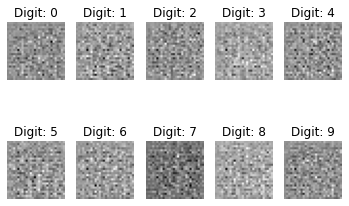

In [ ]:
cgan.train(epochs=200, batch_size=32, sample_interval=200)

In [ ]:
import PIL
from PIL import Image
from keras.preprocessing.image import img_to_array

In [ ]:
(X_train, y_train), (_, _) = mnist.load_data()

# Configure input
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
#X_train = np.expand_dims(X_train, axis=3)
#y_train = y_train.reshape(-1, 1)

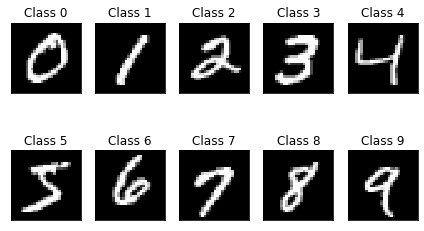

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

In [ ]:
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    img = Image.fromarray(two_d)
    return img

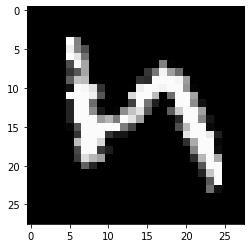

In [ ]:
im = gen_image(X_train[y_train == 5][0])
im = im.transpose(PIL.Image.ROTATE_90)
plt.imshow(im,  cmap='gray', interpolation='none')

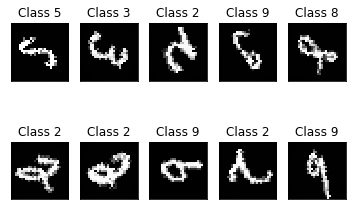

In [ ]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    id = np.random.randint(0, 1000)
    r = 18 * np.random.randint(-10, 10)
    sample = gen_image(X_train[id]).rotate(r)
    plt.imshow(sample, cmap='gray', interpolation='none')
    plt.title("Class %d" % (y_train[id]))
    plt.xticks([])
    plt.yticks([])

In [ ]:
X_dict = {}
for i in range(10):
    X_dict[i] = X_train[y_train==i]

In [ ]:
im = gen_image(X_train[0])
im.filter(PIL.ImageFilter.MaxFilter)

In [ ]:
gen_image(-(np.add(X_train[0], 1))+1)

In [ ]:
gen_image(X_dict[3][1]).rotate(90)

In [ ]:
#np.asarray(sample)
img_to_array(im)

In [ ]:
X_rotated = {}
num_rotation_per_img = 8
angles = [45*i for i in range(num_rotation_per_img)]
for i, img in enumerate(X_train):
    img = gen_image(img)
    label = y_train[i]
    for angle in angles:
        rotated_img = img.rotate(angle)
        img_arr = np.asarray(rotated_img)
        X_rotated[(i,angle)] = img_arr


In [ ]:
Image.fromarray(X_rotated[(12,90)])

NameError: ignored

In [ ]:
import pickle
filename = 'X_rotated.txt'
filehandler = open(filename, 'wb')
pickle.dump(X_rotated, filehandler)

In [ ]:
import pickle

X_rotated

with open('filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

print a == b

ValueError: ignored